# Coursework: The Museum Protection Problem

In [ ]:
#Run if necessary
# !pip install deap
# !pip install glob2

## Import relevant libraries

In [44]:
import numpy as np
import subprocess
import os
import pandas as pd
import matplotlib.pyplot as plt
import random
import array
import csv
import math
import glob as gb
import time

# import deap packages required
from deap import algorithms
from deap import base
from deap import creator
from deap import tools

## Set up  

Depending on the instance you are trying to solve, sest the following parameters


In [2]:
def seed_everything(seed=24):
        random.seed(seed)
        np.random.seed(seed)

# for seeding uncomment this line
# seed_everything(42)

In [3]:
# myinst = None
# nb_cameras = None
# instance_size = None
# num_cells = None
# walls = None

In [4]:
path = './Instances/*'
all_instances = []

for p in gb.glob(path):
    all_instances.append(p)
    
# myinst= all_instances[3]
# instance_file = myinst  # the name of the file specifying the layout - use "" to represent an empty grid to an empty grid

# #  COLAB: upload the instance to colab and
# # instance_file = "./name_of_instance_file"

# nb_cameras = 5 # number of cameras (specificed in the instance definition)
# instance_size  = 100 # number of cells per dimension, i.e total number of cells in the grid is instance_size*instance_size

# num_cells = instance_size*instance_size # total number of cells in the grid



In [5]:

# # create a grid that specifies the walls that can be used later to check that no cameras are positioned on walls

# walls = np.zeros(instance_size*instance_size)


# with open(myinst) as csv_file:
#     csv_reader = csv.reader(csv_file, delimiter=',')
#     for line in csv_reader:
#         column=int(line[0])
#         row=int(line[1])
#         oneD_index = (row * instance_size) + column;
#         walls[oneD_index]=1

In [6]:
def init_prob(idx):
    global myinst
    global instance_file
    global nb_cameras
    global instance_size
    global num_cells
    global walls
    
    myinst = all_instances[idx]
    instance_file = myinst  # the name of the file specifying the layout - use "" to represent an empty grid to an empty grid

    #  COLAB: upload the instance to colab and
    # instance_file = "./name_of_instance_file"

    nb_cameras = int(myinst.split('_')[-2]) # number of cameras (specificed in the instance definition)
    instance_size  = 100 # number of cells per dimension, i.e total number of cells in the grid is instance_size*instance_size

    num_cells = instance_size*instance_size # total number of cells in the grid
    
    walls = np.zeros(instance_size*instance_size)

    with open(myinst) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for line in csv_reader:
            column=int(line[0])
            row=int(line[1])
            oneD_index = (row * instance_size) + column;
            walls[oneD_index]=1

## New Wall Approach

In [7]:

def generate_new_wall(e):
    epsilon = e
    for idx, w in enumerate(walls):
        if w == 1:
            if idx - instance_size - epsilon > 0:
                new_walls[idx - instance_size - epsilon] = 1
            
            if idx - instance_size > 0:
                new_walls[idx - instance_size] = 1
                
            if idx - instance_size + epsilon > 0:
                new_walls[idx - instance_size + epsilon] = 1
                
            if idx - epsilon > 0:
                new_walls[idx - epsilon] = 1
            
            if idx + epsilon < num_cells:
                new_walls[idx + epsilon] = 1
                
            if idx + instance_size - epsilon < num_cells:
                new_walls[idx + instance_size - epsilon] = 1
            
            if idx + instance_size < num_cells:
                new_walls[idx + instance_size] = 1
            
            if idx + instance_size + epsilon < num_cells:
                new_walls[idx + instance_size + epsilon] = 1

## Repair Function

In [8]:
def on_wall(idx):
    if new_walls[idx] == 1:
        return True
    return False

def on_duplicate_repair(ind, idx):
    not_proper_gene = True
    while not_proper_gene:
        random_cell = random.randint(START_END_BOUNDRY, num_cells - START_END_BOUNDRY)
        position_h = random_cell / instance_size
        if position_h > WALL_BOUNDRY \
        and position_h < instance_size - WALL_BOUNDRY \
        and not on_wall(random_cell) \
        and random_cell not in ind:
            not_proper_gene = False
            ind[idx] = random_cell
                    
def on_wall_repair(ind, idx):
    not_proper_gene = True
    while not_proper_gene:
        random_cell = random.randint(START_END_BOUNDRY, num_cells - START_END_BOUNDRY)
        position_h = random_cell / instance_size
        if position_h > WALL_BOUNDRY \
        and position_h < instance_size - WALL_BOUNDRY \
        and not on_wall(random_cell) \
        and random_cell not in ind:
            not_proper_gene = False
            ind[idx] = random_cell
            
            
def repair(ind):
    for idx, g in enumerate(ind):
        
        for idx2, j in enumerate(ind):
            if j == g and idx != idx2:
                on_duplicate_repair(ind, idx)
                continue
        
        if on_wall(g):
            on_wall_repair(ind, idx)

In [9]:
# ind = [4788, 6950, 7031, 7031, 5921]
# repair(ind)
# print(ind)

## Distance Approach

In [10]:
def distance_camera(idx1, idx2):
    y1 = int(idx1/instance_size)
    y2 = int(idx2/instance_size)
    x1 = int(idx1%instance_size)
    x2 = int(idx2%instance_size)
    distance = int(math.sqrt((x1-x2)**2 + (y1-y2)**2))
    return distance

In [11]:
def check_distance(ind):

    for idx, el in enumerate(ind):
        for el2 in ind[idx+1:]:
            if el != el2 and distance_camera(el, el2) < random.randint(10,15):
                return False
    return True
        

## Converter

In [12]:
def custom2bin(ind):
    solution=[]
    for i in range(0, num_cells):
        if i in ind:
            solution.append(1)
        else:
            solution.append(0)
    return solution

In [13]:
# Example of custom2bin
# custom2bin([5722, 1853, 4148, 9940, 7780])

In [54]:
def custom2xy(ind):
    tmp = []
    for i in ind:
        y = int(i/instance_size)
        x = int(i%instance_size)
        tmp.append((x,y))
    return tmp

## Set up the fitness calculations 

This calls an external executable to return a fitness value. You cannot modify the code in this executable. 


1. If you are running code using **Google Colab**, you neyou must upload the executables called "bit_cam_napier_colab"  and "bit_cam_napier_visualisation_colab" to Colab and uncomment the line of code at tge top of the next cell

2. If you are running on **Windows using Anaconda**, then your code needs to call the executables "bit_cam_napier_windows.exe" and "bit_cam_napier_visualisation_windows.exe" - you need to specify the exact path to these on your system in the code below

3. If you are running on **Mac using Anaconda**, then your code needs to call the executables "bit_cam_napier_mac.exe" and "bit_cam_napier_visualisation_mac.exe" - you need to specify the exact path to these on your system in the code below

The call to the external function is wrapped inside an evaluation function called **eval_function()** .. this has the standard form used by DEAP and should be registered with the toolbox as usual. Read the following carefully.    You can any code you wish inside this function but it must always call the external *objective_function()* with a valid solution. This is defined below


 - The external "objective_function" needs to be passed a list of length (where n is the number of cells) where each value is 0 or 1.
- There must be exactly c values set to 1, where c= number of cameras
- Regardless of the representation you use, **you must turn a DEAP individual into a list of the form specified above** before calling the objective_function


**WARNING!!! You should only call the *objective_function* with a list that has exactly *c* bits set to 1**

If this is not the case, then you should assign a fitness value to the individual without calling the external  *objective_function*. You can choose how to set this - the fitness you assign should reflect the fact that the solution is invalid.  For a valid solution, the worst possible fitness is equal to *num_cells*, i.e. no cell is covered. Therefore, the fitness you choose to assign to an invalid solution should be worse than this value

In [14]:

# set the correct binary depending on your machine/setup - you need to choose one of the options below and set the path correctly

# for MacOS
path_binary = "./CourseworkExecutables/bit_cam_napier_mac"
path_binary_vis = "./CourseworkExecutables/bit_cam_napier_visualisation_mac"


# On Windows: change the following to the location of the binary on your system
# path_binary = "path-to/bit_cam_napier_windows.exe"
# path_binary_vis = "path-to/bit_cam_napier_visualisation_windows.exe"


# on Colab: YOU MUST UPLOAD THE BINARIES TO COLAB
#!chmod 755 -R ./bit_cam_napier_colab
#!chmod 755 -R ./bit_cam_napier_visualisation_colab


# Do NOT modify this code - this calls an external binary with a solution
def objective_function(x, instance_size, nb_cameras, instance_file):
    params = ['%.16g' % a for a in x]
    cmd = [path_binary,str(instance_size),str(nb_cameras)]+params+[instance_file]
    s = subprocess.check_output(cmd)
    return float(s)


# Do NOT modify: this checks whether a camera is positioned on top of wall in a solution
def check_walls(solution, inst):
    clashes=0
    for i in range(0, len(solution)):
        if (walls[i] == 1 and solution[i]==1):
            clashes+=1
            
    return(clashes)

In [15]:
def eval_function(ind):

    # checking duplicates and on walls    
    repair(ind)
    
    # converter
    fitness = objective_function(custom2bin(ind), instance_size, nb_cameras, instance_file)
    return fitness,
    

## Set up the DEAP toolbox

This sets up a  very basic EA. It uses standard operators to manipulate a list of 0,1s.  You can change these operators for others from the DEAP toolbox or write your own

In [16]:
def init_function(icls, size):
    ind = icls(np.zeros(size))
    try_again = True
    while try_again:
        for i in range(size):
            not_found = True
            while not_found:
                r = random.randint(START_END_BOUNDRY, num_cells - START_END_BOUNDRY)
                if r not in ind \
                and not on_wall(r) \
                and (r > instance_size and r < num_cells - instance_size) \
                and ((r/instance_size) > WALL_BOUNDRY and (r/instance_size)< instance_size - WALL_BOUNDRY) :

                    ind[i] = r
                    not_found = False
        try_again = check_distance(ind)
            
    return ind

In [17]:
def custom_cx(ind1, ind2):
    return [ind1, ind2],

In [18]:
def custom_mute(ind, indpb):
    for idx, i in enumerate(ind):
        if random.random() > indpb:
            try_again = True
            while try_again:
                try_again = False
                epsilon = random.randint(1,5)
                direction = random.randint(1,8)
                if direction == 1 and i + epsilon < num_cells and not on_wall(i + epsilon):
                    ind[idx] = i + epsilon
                elif direction == 2 and i + (epsilon * instance_size + epsilon) < num_cells and not on_wall(i + (epsilon * instance_size + epsilon)):
                    ind[idx] = i + (epsilon * instance_size + epsilon)
                elif direction == 2 and i + (epsilon * instance_size) < num_cells and not on_wall(i + (epsilon * instance_size)):
                    ind[idx] = i + (epsilon * instance_size)
                elif direction == 4 and i + (epsilon * instance_size - epsilon) < num_cells and not on_wall(i + (epsilon * instance_size - epsilon)):
                    ind[idx] = i + (epsilon * instance_size - epsilon)
                elif direction == 3 and i - epsilon > START_END_BOUNDRY and not on_wall(i - epsilon):
                    ind[idx] = i - epsilon
                elif direction == 6 and i - (epsilon * instance_size - epsilon) > START_END_BOUNDRY and not on_wall(i - (epsilon * instance_size - epsilon)):
                    ind[idx] = i - (epsilon * instance_size - epsilon)
                elif direction == 4 and i - (epsilon * instance_size) > START_END_BOUNDRY and not on_wall(i - (epsilon * instance_size)):
                    ind[idx] = i - (epsilon * instance_size)
                elif direction == 8 and i - (epsilon * instance_size + epsilon) > START_END_BOUNDRY and not on_wall(i - (epsilon * instance_size + epsilon)):
                    ind[idx] = i - (epsilon * instance_size + epsilon)
                else:
                    ind[idx] = random.randint(START_END_BOUNDRY, num_cells - START_END_BOUNDRY)

    return ind,

In [19]:
def create_alg(indpb, tournsize):
    from deap import creator
    
    # define the fitness class and creare an individual class - set up as a minimisation problem
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMin)

    # create a toolbox
    global toolbox
    toolbox = base.Toolbox()


    #an individual consists of repeated genes of type "attr_bool"  - we specify num_cells genes
    toolbox.register("individual", init_function, creator.Individual, nb_cameras)

    #  a population consist of a list of individuals
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)


    # register all operators we need with the toolbox
    toolbox.register("evaluate", eval_function)
    toolbox.register("mate", custom_cx)
    toolbox.register("mutate", custom_mute, indpb=indpb)
    toolbox.register("select", tools.selTournament, tournsize=tournsize)


In [20]:
def main(ngen=40, popsize=400, indpb=0.7, tournsize=350):
    
    create_alg(indpb, tournsize)
    # choose a population size: e.g. 50
    pop = toolbox.population(n=popsize)

    # keep track of the single best solution found
    hof = tools.HallOfFame(1)

    # create a statistics object: we can log what ever statistics we want using this. We use the numpy Python library
    # to calculate the stats and label them with convenient labels
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)

    # run the algorithm: we need to tell it what parameters to use
    # cxpb = crossover probability; mutpb = mutation probability; ngen = number of iterations
    pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.0, mutpb=0.5, ngen=ngen,
                                   stats=stats, halloffame=hof, verbose=False)

    return pop, log, hof

## Plotting (optional)

In [57]:
def plotter(log, ngen):

    gen = log.select("gen")
    fit_max = log.select("max")
    fit_min = log.select("min")
    fit_avg = log.select("avg")

    fig, ax1 = plt.subplots()

    # set this to the number of generations in the EA
    my_gens=ngen
    # add a line to indicate "valid solutions" i.e solutions with the correct number of cameras. Any solution below this line is valid
    worst_valid = [num_cells]*(my_gens+1)

    line1 = ax1.plot(gen, fit_max, "b-", label="max Fitness", color="r")
    line2 = ax1.plot(gen, fit_min, "b-", label="min Fitness", color="b")
    line3 = ax1.plot(gen , fit_avg, "b-", label="avg Fitness", color="g")
    line4 = ax1.plot(gen, worst_valid, "b-", label="worst valid soluton", color="y" )
    ax1.set_xlabel("Generations")
    ax1.set_ylabel("Fitness", color="b")
    for tl in ax1.get_yticklabels():
        tl.set_color("b")

    #plt.ylim(0,num_cells+10)   # change the scale on the graph to see the valid solutions better

    lns = line1+line2+line3+line4
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs, loc="center right")



# Visualisation Tools

The code sets up some functions to allow you do visualise solutions. You shouldn't need to alter the code in the cell below (make sure the variable *path_binary_vis* is set to the correct binary at the start)



In [61]:

# Run this cell to define the functions
def solution_converter(index, instance_size):
    counter = 0
    for i in range(instance_size):
        for j in range(instance_size):
            if (counter == index):
                return i,j
            else:
                counter+=1

# assumes path_binary is already set 
def visualise_objective_function(x, instance_size, nb_cameras, instance_file):
    params = ['%.16g' % a for a in x]
    cmd = [path_binary_vis,str(instance_size),str(nb_cameras)]+params+[instance_file]
    with open("temp_results.csv",'w') as fd:
        s = subprocess.call(cmd, stdout=fd)
    # Plotting the probability of detection
    data = pd.read_csv("temp_results.csv")
    values = np.array(data["value"])
    values[values < 0.5] = 0
    values = values.reshape(instance_size,instance_size)
    plt.imshow(values,cmap="Reds")
    # Plotting cameras
    cameras_indices = [index for (index, item) in enumerate(list(x)) if item == 1]
    for c in cameras_indices:
        x,y = solution_converter(c, instance_size=instance_size)
        plt.scatter(y,x,c="blue",marker="D")
    # Plotting walls (if any)
    if (instance_file != ""):
        walls = pd.read_csv(instance_file,header=None)
        plt.scatter(walls[1],walls[0],c="black", marker="_")
        plt.title(instance_file.split('/')[-1])
    plt.xlim(0,instance_size-1)
    plt.xlabel("y")
    plt.ylim(0,instance_size-1)
    plt.ylabel("x")
    plt.show()
    


### Visualising a solution

Two examples are given:
- visualising a random solution
- visualising an invidual returned from the EA


In [58]:

# sol = custom2bin(hof[0])

# actual_cameras=nb_cameras  # need to pass the actual numbers of cameras in the solution, regardless of whether it is valid

# visualise_objective_function(sol, instance_size=instance_size, nb_cameras=actual_cameras, instance_file=myinst)


# Experimenting

This runs the basic EA once. You can adapt this to run repeated expts. etc.

In [62]:
def make_experiments():
    
    for i in range(len(all_instances)):
        init_prob(i)
        
        print(30*'#')
        print("Instance: %s\n" % (myinst))
        
        global WALL_BOUNDRY
        global START_END_BOUNDRY
        WALL_BOUNDRY = 20
        START_END_BOUNDRY = instance_size + WALL_BOUNDRY
        
        # Generating new walls approach 
        global new_walls
        new_walls = np.zeros(num_cells)

        for i in range(8):
            generate_new_wall(i)
        
        for i in range(instance_size):
            for j in range(8):
                new_walls[i*instance_size + j] = 1
                new_walls[i*instance_size + instance_size - j -1] = 1

        new_walls[0: instance_size] = 1
        new_walls[num_cells - instance_size: num_cells-1] = 1
        
        # running exp
        ngen_popsize = [(10, 100), (10,150), (15, 200), (15, 250), (30,250), (40, 400)]
        all_best = []
        best_parameters = None
        best_best = None
        for iteration in ngen_popsize:
            
            ngen = iteration[0]
            popsize = iteration[1]
            
            t1 = time.time()
            pop, log, hof = main(ngen, popsize, 0.7, int(popsize*0.8))
            t2 = time.time()
            
            best = hof[0].fitness.values[0]   # best fitness found is stored at index 0 in the hof list
            
            for b in all_best:
                if best < b:
                    best_parameters = iteration
                    best_best = hof[0]
                    
            if not all_best:
                best_parameters = iteration
                best_best = hof[0]
                
            all_best += [best]
            
            minimum = log.select("min")  # min fitness per generation stored in log
            print("Iteration: ngen=%s , popsize=%s" %(iteration[0], iteration[1]))
            for i, fit in enumerate(minimum):
                if fit == best:
                    print("Min fitness found is %s at gen %s " % (best, i))
                    break

            print("The best individual is %s" % (hof[0]))
            print("Camera cooridinations: %s" % (custom2xy(hof[0])))
            print("Time: %ss" % (t2 - t1))
            print('-'*30)
            # plotting exp        
            # plotter(log, ngen)
        print("Avg of fitness: %s" % (np.mean(all_best)))
        print("Best parameters: ngen= %s , popsize=%s" % (best_parameters[0], best_parameters[1]))
        print(30*'#')
        
        sol = custom2bin(best_best)

        actual_cameras=nb_cameras  # need to pass the actual numbers of cameras in the solution, regardless of whether it is valid

        visualise_objective_function(sol, instance_size=instance_size, nb_cameras=actual_cameras, instance_file=myinst)


##############################
Instance: ./Instances/NMScotlandFloor5Right_5_cameras.csv

Iteration: ngen=10 , popsize=100
Min fitness found is 964.0 at gen 10 
The best individual is [7817, 7166, 8777, 1922, 2577]
Camera cooridinations: [(17, 78), (66, 71), (77, 87), (22, 19), (77, 25)]
Time: 13.462024211883545s
------------------------------
Iteration: ngen=10 , popsize=150
Min fitness found is 745.0 at gen 10 
The best individual is [2474, 8249, 7011, 7380, 1926]
Camera cooridinations: [(74, 24), (49, 82), (11, 70), (80, 73), (26, 19)]
Time: 19.598262071609497s
------------------------------
Iteration: ngen=15 , popsize=200
Min fitness found is 802.0 at gen 15 
The best individual is [2848, 7921, 7877, 2477, 2313]
Camera cooridinations: [(48, 28), (21, 79), (77, 78), (77, 24), (13, 23)]
Time: 37.37953186035156s
------------------------------
Iteration: ngen=15 , popsize=250
Min fitness found is 892.0 at gen 15 
The best individual is [2376, 9181, 2122, 7819, 6263]
Camera cooridinati

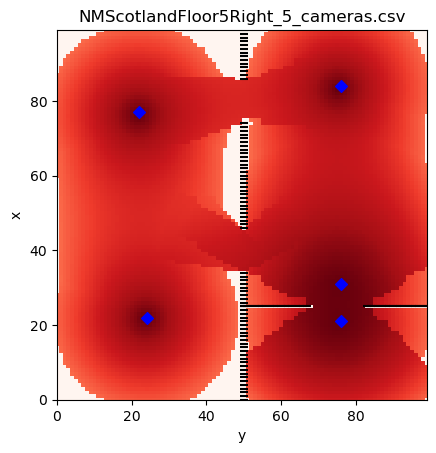

##############################
Instance: ./Instances/WallsTest2_5_cameras.csv



/Users/nima/anaconda3/lib/python3.11/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Users/nima/anaconda3/lib/python3.11/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Iteration: ngen=10 , popsize=100
Min fitness found is 2169.0 at gen 10 
The best individual is [5260, 2416, 7616, 8677, 1778]
Camera cooridinations: [(60, 52), (16, 24), (16, 76), (77, 86), (78, 17)]
Time: 13.121864318847656s
------------------------------
Iteration: ngen=10 , popsize=150
Min fitness found is 2057.0 at gen 10 
The best individual is [8323, 8278, 5351, 1779, 2221]
Camera cooridinations: [(23, 83), (78, 82), (51, 53), (79, 17), (21, 22)]
Time: 19.898914098739624s
------------------------------
Iteration: ngen=15 , popsize=200
Min fitness found is 2012.0 at gen 15 
The best individual is [8323, 1823, 8477, 5251, 1676]
Camera cooridinations: [(23, 83), (23, 18), (77, 84), (51, 52), (76, 16)]
Time: 37.86540913581848s
------------------------------
Iteration: ngen=15 , popsize=250
Min fitness found is 2040.0 at gen 15 
The best individual is [1876, 1721, 5250, 8377, 8222]
Camera cooridinations: [(76, 18), (21, 17), (50, 52), (77, 83), (22, 82)]
Time: 46.94890093803406s
-----

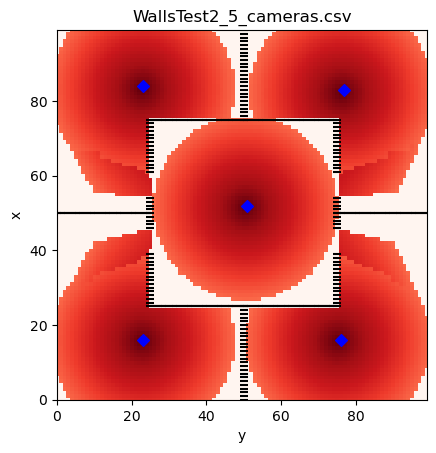

##############################
Instance: ./Instances/WallsTest1_5_cameras.csv



/Users/nima/anaconda3/lib/python3.11/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Users/nima/anaconda3/lib/python3.11/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Iteration: ngen=10 , popsize=100
Min fitness found is 2041.0 at gen 10 
The best individual is [6889, 7318, 5014, 2053, 8449]
Camera cooridinations: [(89, 68), (18, 73), (14, 50), (53, 20), (49, 84)]
Time: 13.328836679458618s
------------------------------
Iteration: ngen=10 , popsize=150
Min fitness found is 2020.0 at gen 10 
The best individual is [8849, 1954, 6888, 4914, 7420]
Camera cooridinations: [(49, 88), (54, 19), (88, 68), (14, 49), (20, 74)]
Time: 20.55520486831665s
------------------------------
Iteration: ngen=15 , popsize=200
Min fitness found is 1996.0 at gen 14 
The best individual is [7224, 1739, 5116, 4883, 8960]
Camera cooridinations: [(24, 72), (39, 17), (16, 51), (83, 48), (60, 89)]
Time: 38.626792907714844s
------------------------------
Iteration: ngen=15 , popsize=250
Min fitness found is 1955.0 at gen 15 
The best individual is [7423, 1743, 4913, 8852, 5485]
Camera cooridinations: [(23, 74), (43, 17), (13, 49), (52, 88), (85, 54)]
Time: 48.03920817375183s
-----

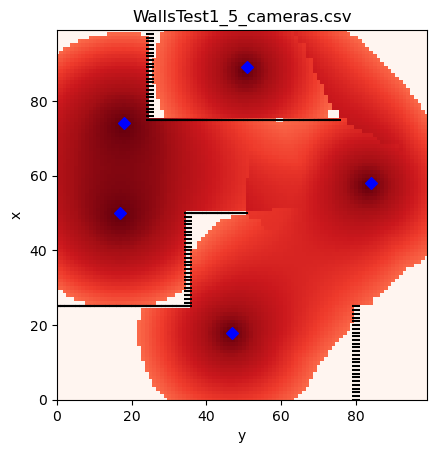

##############################
Instance: ./Instances/NMScotlandFloor5Left_5_cameras.csv



/Users/nima/anaconda3/lib/python3.11/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Users/nima/anaconda3/lib/python3.11/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Iteration: ngen=10 , popsize=100
Min fitness found is 1020.0 at gen 10 
The best individual is [7867, 7720, 5878, 1379, 2623]
Camera cooridinations: [(67, 78), (20, 77), (78, 58), (79, 13), (23, 26)]
Time: 13.921130895614624s
------------------------------
Iteration: ngen=10 , popsize=150
Min fitness found is 1308.0 at gen 10 
The best individual is [2524, 7719, 8077, 2277, 8040]
Camera cooridinations: [(24, 25), (19, 77), (77, 80), (77, 22), (40, 80)]
Time: 20.131659984588623s
------------------------------
Iteration: ngen=15 , popsize=200
Min fitness found is 1249.0 at gen 15 
The best individual is [7441, 8019, 8080, 2420, 2576]
Camera cooridinations: [(41, 74), (19, 80), (80, 80), (20, 24), (76, 25)]
Time: 41.408364057540894s
------------------------------
Iteration: ngen=15 , popsize=250
Min fitness found is 968.0 at gen 15 
The best individual is [1376, 2520, 8080, 8020, 5268]
Camera cooridinations: [(76, 13), (20, 25), (80, 80), (20, 80), (68, 52)]
Time: 49.78303122520447s
-----

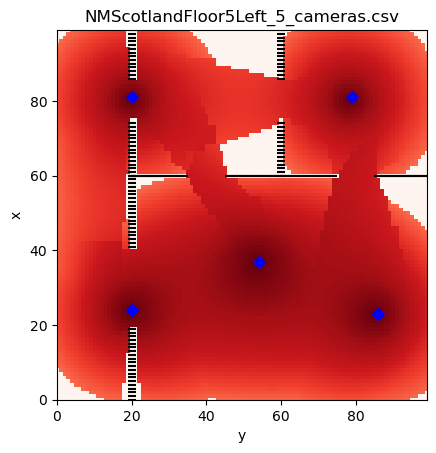

##############################
Instance: ./Instances/MerchistonD._5_cameras.csv



/Users/nima/anaconda3/lib/python3.11/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Users/nima/anaconda3/lib/python3.11/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Iteration: ngen=10 , popsize=100
Min fitness found is 2452.0 at gen 10 
The best individual is [874, 4186, 7109, 3335, 8655]
Camera cooridinations: [(74, 8), (86, 41), (9, 71), (35, 33), (55, 86)]
Time: 13.059736013412476s
------------------------------
Iteration: ngen=10 , popsize=150
Min fitness found is 2364.0 at gen 10 
The best individual is [2280, 7222, 1622, 5409, 7776]
Camera cooridinations: [(80, 22), (22, 72), (22, 16), (9, 54), (76, 77)]
Time: 20.705125093460083s
------------------------------
Iteration: ngen=15 , popsize=200
Min fitness found is 2001.0 at gen 15 
The best individual is [7211, 3135, 7180, 7548, 1476]
Camera cooridinations: [(11, 72), (35, 31), (80, 71), (48, 75), (76, 14)]
Time: 37.92084288597107s
------------------------------
Iteration: ngen=15 , popsize=250
Min fitness found is 2000.0 at gen 15 
The best individual is [8147, 6880, 1876, 3136, 7114]
Camera cooridinations: [(47, 81), (80, 68), (76, 18), (36, 31), (14, 71)]
Time: 47.24445986747742s
---------

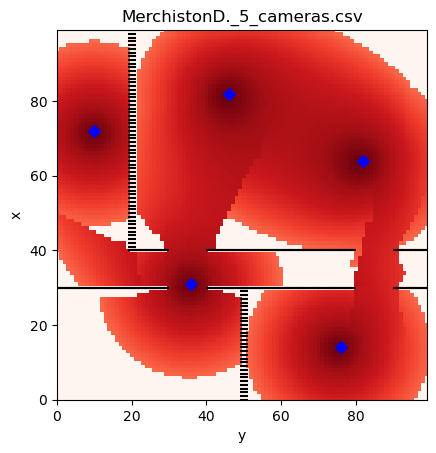

In [63]:
make_experiments()